# Feltáró adatelemzés és adatvizualizáció

Ez a notebook egyedi vizualizációt tartalmaz három könyvtárból (matplotlib, seaborn, plotly), valamint rövid EDA-t és minden ábra után következtetést.


In [78]:
# Könyvtárak importja és adatok betöltése
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (8, 5)

# Seaborn beépített adatok
tips = sns.load_dataset('tips')
penguins = sns.load_dataset('penguins')
flights = sns.load_dataset('flights')

# Plotly beépített adatok
iris = px.data.iris()
gap = px.data.gapminder()

tips.head(), penguins.head(), flights.head(), iris.head(), gap.head()[:3]


(   total_bill   tip     sex smoker  day    time  size
 0       16.99  1.01  Female     No  Sun  Dinner     2
 1       10.34  1.66    Male     No  Sun  Dinner     3
 2       21.01  3.50    Male     No  Sun  Dinner     3
 3       23.68  3.31    Male     No  Sun  Dinner     2
 4       24.59  3.61  Female     No  Sun  Dinner     4,
   species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
 0  Adelie  Torgersen            39.1           18.7              181.0   
 1  Adelie  Torgersen            39.5           17.4              186.0   
 2  Adelie  Torgersen            40.3           18.0              195.0   
 3  Adelie  Torgersen             NaN            NaN                NaN   
 4  Adelie  Torgersen            36.7           19.3              193.0   
 
    body_mass_g     sex  
 0       3750.0    Male  
 1       3800.0  Female  
 2       3250.0  Female  
 3          NaN     NaN  
 4       3450.0  Female  ,
    year month  passengers
 0  1949   Jan         112
 1  19

## Rövid EDA - Exploratory Data Analysis
Megnézzük a legfontosabb jellemzőket: sorok száma, hiányzók, típusok és alapstatisztikák.


In [79]:
def quick_eda(df, name):
    print(f'--- {name} ---')
    print('Shape:', df.shape)
    print('Dtypes:')
    print(df.dtypes)
    print('Missing values per column:')
    print(df.isna().sum())
    if df.select_dtypes(include=np.number).shape[1] > 0:
        print(df.describe().T)
    print('\n')

for df, name in [(tips, 'tips'), (penguins, 'penguins'), (flights, 'flights'), (iris, 'iris'), (gap, 'gapminder')]:
    quick_eda(df, name)


--- tips ---
Shape: (244, 7)
Dtypes:
total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object
Missing values per column:
total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64
            count       mean       std   min      25%     50%      75%    max
total_bill  244.0  19.785943  8.902412  3.07  13.3475  17.795  24.1275  50.81
tip         244.0   2.998279  1.383638  1.00   2.0000   2.900   3.5625  10.00
size        244.0   2.569672  0.951100  1.00   2.0000   2.000   3.0000   6.00


--- penguins ---
Shape: (344, 7)
Dtypes:
species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object
Missing values per column:
species               0
island       

# Matplotlib vizualizációk (4)
Adatmodellek: errorbar, stem, eventplot.


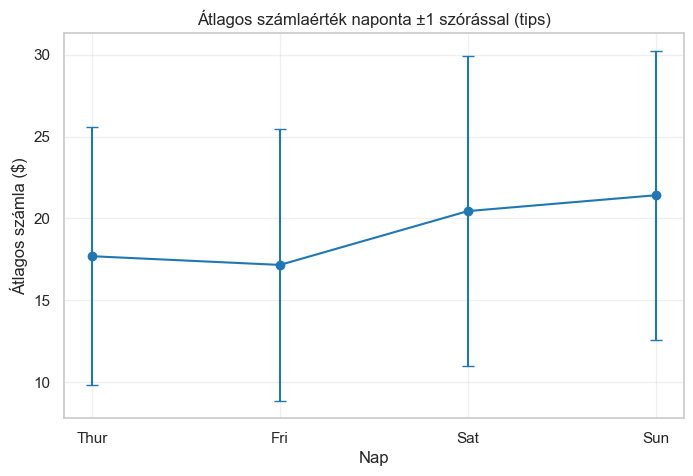

In [80]:
# 1) Errorbar: napi átlagos számlaérték hibasávval (tips)
grp = tips.groupby('day', observed=True)['total_bill'].agg(['mean','std']).reset_index()
plt.figure()
plt.errorbar(grp['day'], grp['mean'], yerr=grp['std'], fmt='o-', capsize=4, color='tab:blue')
plt.title('Átlagos számlaérték naponta ±1 szórással (tips)')
plt.xlabel('Nap')
plt.ylabel('Átlagos számla ($)')
plt.grid(True, alpha=0.3)
plt.show()


Következtetés: A napok között mérsékelt különbség látható az átlagos számlaértékben. Hétvégén jellemzően magasabb a költés.


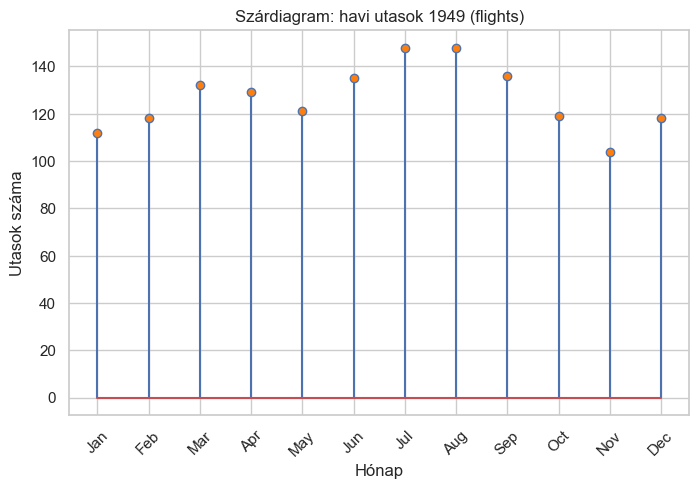

In [81]:
# 2) Stem plot: havi utasok (flights) egy évre (1949)
f49 = flights[flights['year']==1949].copy()
months = pd.Categorical(f49['month'], categories=list(flights['month'].unique()), ordered=True)
f49 = f49.assign(month_cat=months).sort_values('month_cat')
plt.figure()
# Kompatibilis visszatérési érték kezelés (StemContainer vs tuple)
stem_ret = plt.stem(range(len(f49)), f49['passengers'])
try:
    markerline = stem_ret.markerline
except AttributeError:
    markerline = stem_ret[0]
plt.setp(markerline, 'markerfacecolor', 'tab:orange')
plt.title('Szárdiagram: havi utasok 1949 (flights)')
plt.xlabel('Hónap')
plt.ylabel('Utasok száma')
# Hónapnevek az x-tengelyen a rendezett kategória szerint
plt.xticks(range(len(f49)), f49['month_cat'].astype(str), rotation=45)
plt.show()


Következtetés: Az év előrehaladtával nő az utasforgalom, és nyár (július–augusztus) környékén csúcsosodik.


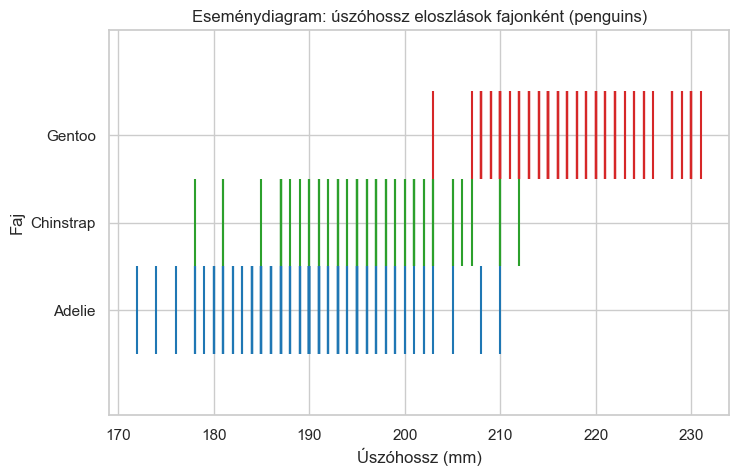

In [82]:
# 3) Eventplot: pingvinek úszóhossz (flipper_length_mm) fajonként
vals = [penguins[penguins['species']==sp]['flipper_length_mm'].dropna().values for sp in penguins['species'].dropna().unique()]
plt.figure()
plt.eventplot(vals, orientation='horizontal', colors=['tab:blue','tab:green','tab:red'])
plt.yticks(range(len(vals)), penguins['species'].dropna().unique())
plt.title('Eseménydiagram: úszóhossz eloszlások fajonként (penguins)')
plt.xlabel('Úszóhossz (mm)')
plt.ylabel('Faj')
plt.show()


Következtetés: A fajok között jól elkülönülő úszóhossz-tartományok figyelhetők meg.


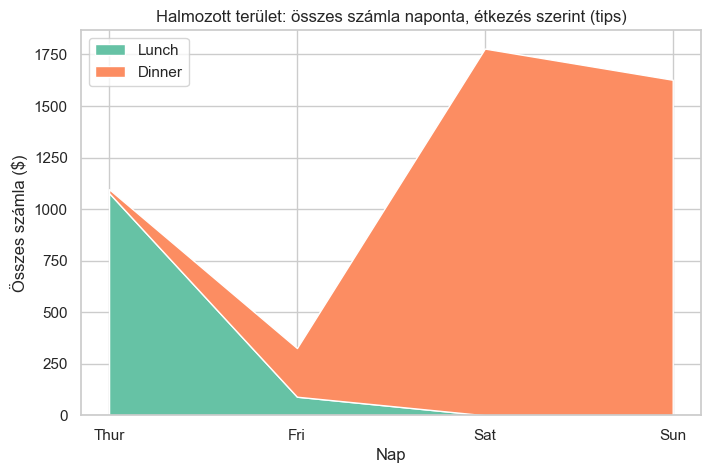

In [83]:
# 4) Stackplot: Borravaló naponta, étkezés típusa szerint (Lunch vs Dinner)
pivot = tips.pivot_table(index='day', columns='time', values='total_bill', aggfunc='sum', observed=True).fillna(0)
order = ['Thur','Fri','Sat','Sun']
pivot = pivot.reindex(order)
x = np.arange(len(pivot.index))
plt.figure()
plt.stackplot(x, pivot.get('Lunch', pd.Series([0]*len(x))), pivot.get('Dinner', pd.Series([0]*len(x))), labels=['Lunch','Dinner'], colors=['#66c2a5','#fc8d62'])
plt.xticks(x, pivot.index)
plt.title('Halmozott terület: összes számla naponta, étkezés szerint (tips)')
plt.xlabel('Nap')
plt.ylabel('Összes számla ($)')
plt.legend(loc='upper left')
plt.show()


Következtetés: A hétvégi napokon magasabb az összköltés, és a Dinner dominál a forgalomban.


# Seaborn vizualizációk (4)
Egyedi típusok itt: pairplot és jointplot (kde).


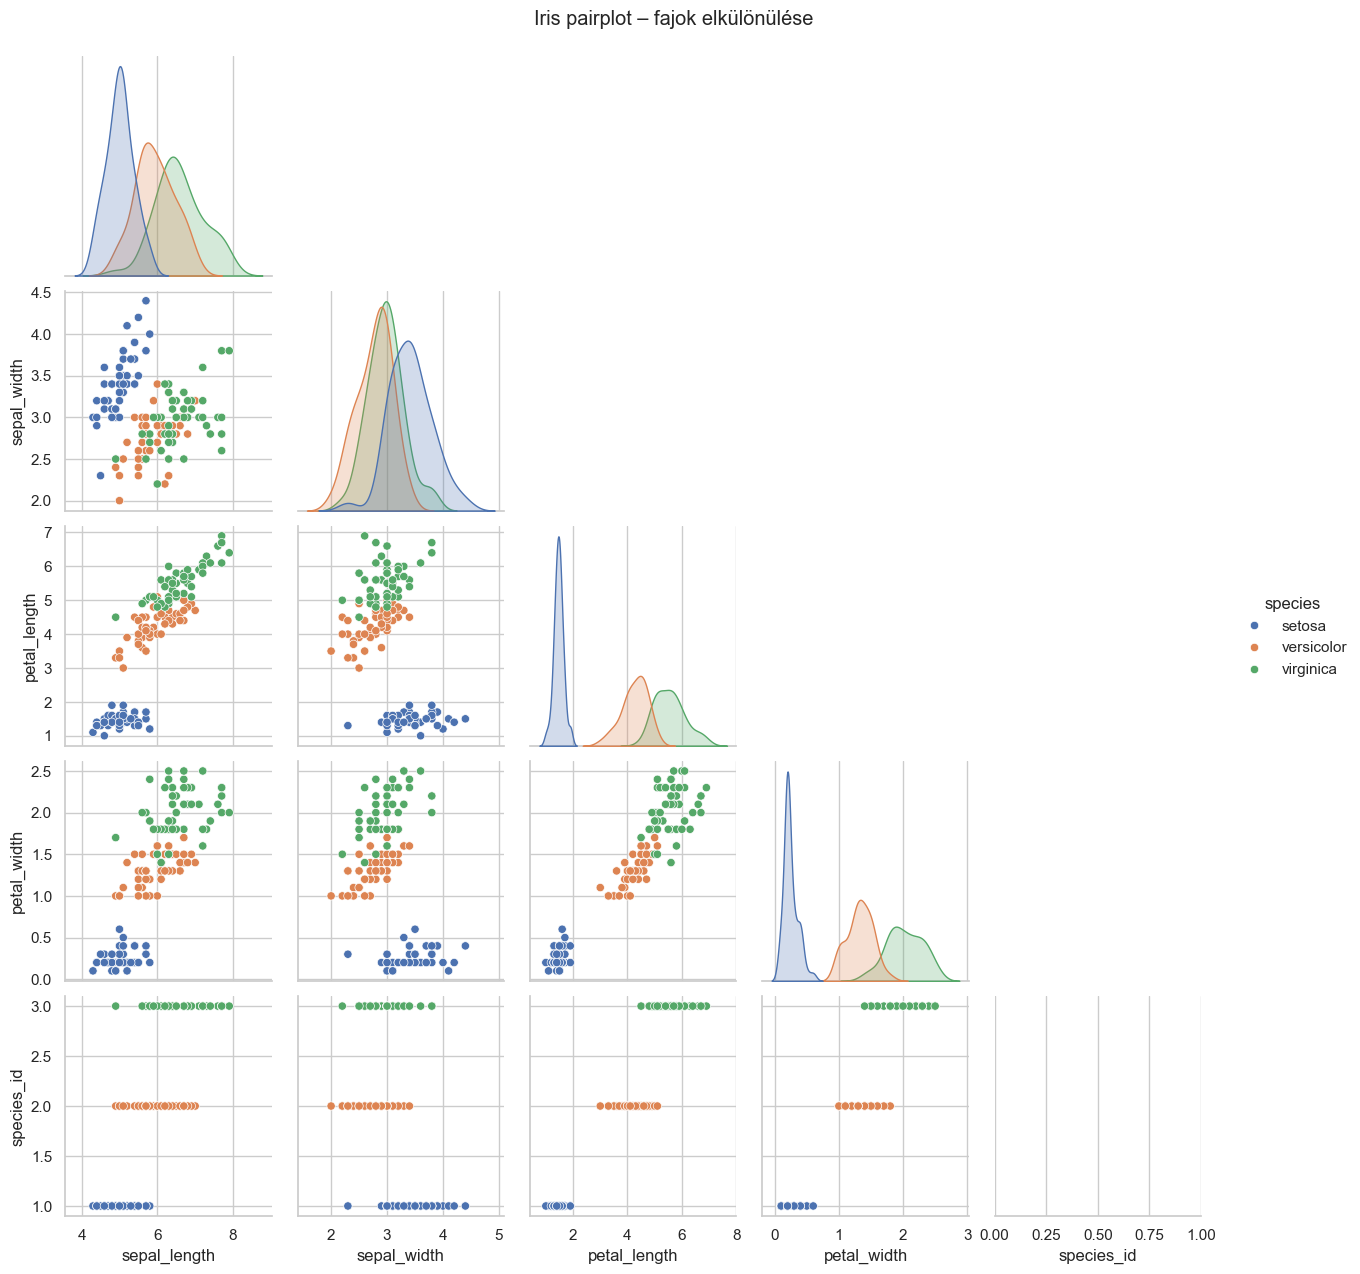

In [84]:
# 1) Pairplot: iris minta
g = sns.pairplot(iris, hue='species', corner=True, diag_kind='kde')
g.fig.suptitle('Iris pairplot – fajok elkülönülése', y=1.02)
plt.show()


Következtetés: A fajok több dimenzióban is jól elkülönülnek, különösen a szirom méretekben.


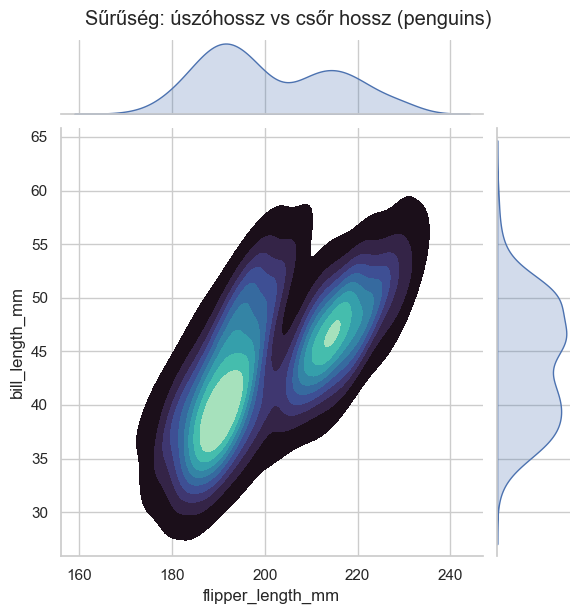

In [85]:
# 2) Jointplot (KDE): penguins – úszóhossz vs csőr hossz
sns.jointplot(data=penguins, x='flipper_length_mm', y='bill_length_mm', kind='kde', fill=True, cmap='mako')
plt.suptitle('Sűrűség: úszóhossz vs csőr hossz (penguins)', y=1.02)
plt.show()


Következtetés: A sűrűségi régiók jelzik a tipikus méretkombinációkat, szélső értékek ritkábbak.


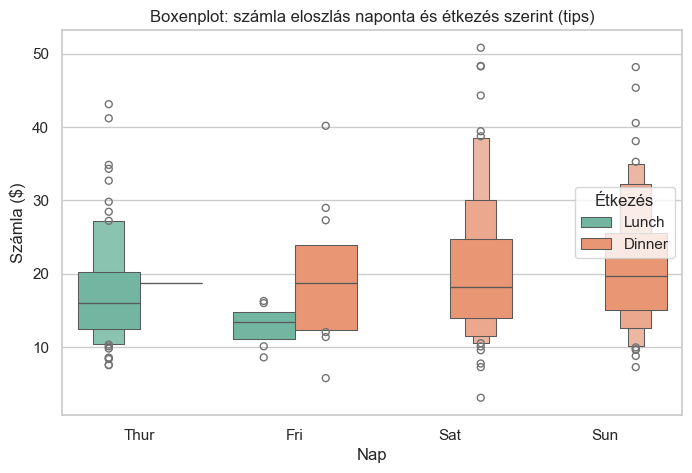

In [86]:
# 3) Boxenplot: számla eloszlás naponta (tips)
plt.figure()
sns.boxenplot(data=tips, x='day', y='total_bill', hue='time', palette='Set2')
plt.title('Boxenplot: számla eloszlás naponta és étkezés szerint (tips)')
plt.xlabel('Nap')
plt.ylabel('Számla ($)')
plt.legend(title='Étkezés')
plt.show()


Következtetés: A hétvégéken magasabb medián és nagyobb szórás figyelhető meg, különösen Dinner esetén.


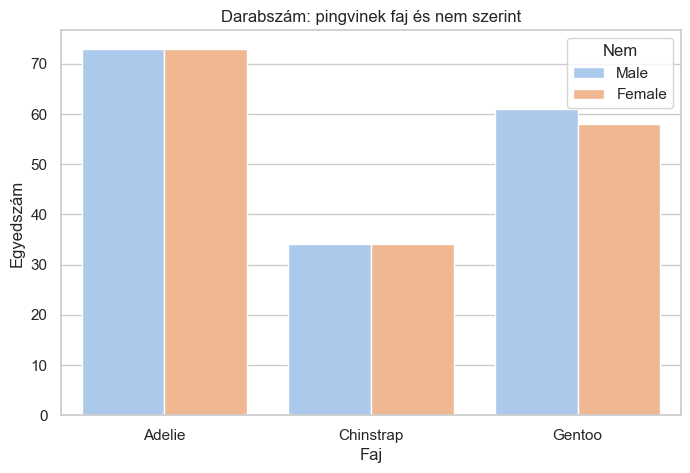

In [87]:
# 4) Countplot: penguins fajok és nemek megoszlása
plt.figure()
sns.countplot(data=penguins, x='species', hue='sex', palette='pastel')
plt.title('Darabszám: pingvinek faj és nem szerint')
plt.xlabel('Faj')
plt.ylabel('Egyedszám')
plt.legend(title='Nem')
plt.show()


Következtetés: A fajok eloszlása eltérő, és a nemek aránya fajonként minimálisan változhat.


# Plotly vizualizációk (4)
Egyedi típusok itt: treemap, 3D scatter, sunburst, choropleth.


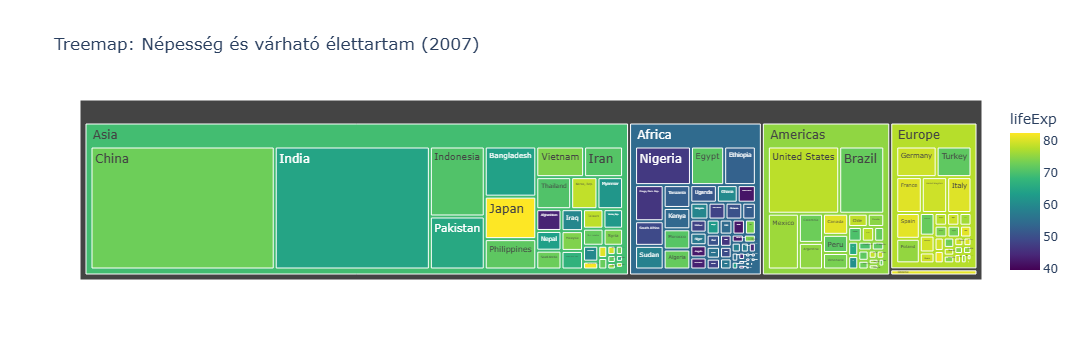

In [88]:
# 1) Treemap: népesség hierarchiája (kontinens -> ország), 2007
gap2007 = gap[gap['year']==2007]
fig = px.treemap(gap2007, path=['continent','country'], values='pop', color='lifeExp', color_continuous_scale='Viridis',
                 title='Treemap: Népesség és várható élettartam (2007)')
fig.show()


Következtetés: Ázsiában és Afrikában összpontosul a népesség jelentős része, az élettartam pedig régiónként eltérő.


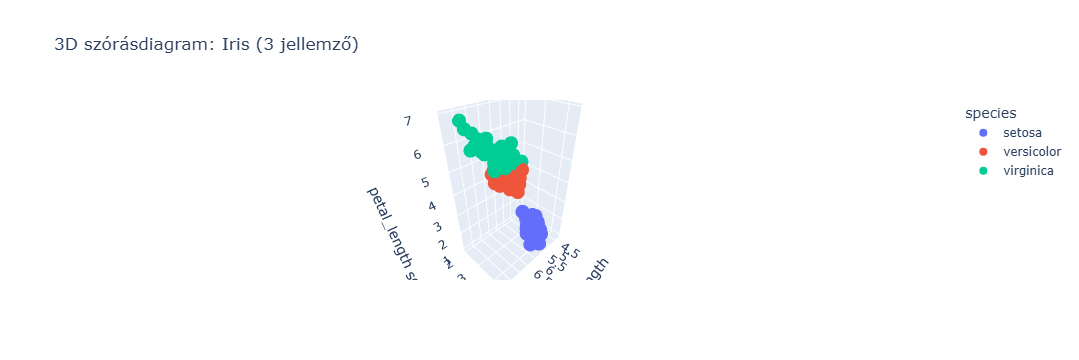

In [89]:
# 2) 3D scatter: iris három jellemzője faj szerint
fig = px.scatter_3d(iris, x='sepal_length', y='sepal_width', z='petal_length', color='species',
                    title='3D szórásdiagram: Iris (3 jellemző)')
fig.show()


Következtetés: A 3D térben a fajok elválása még kifejezettebbé válik.


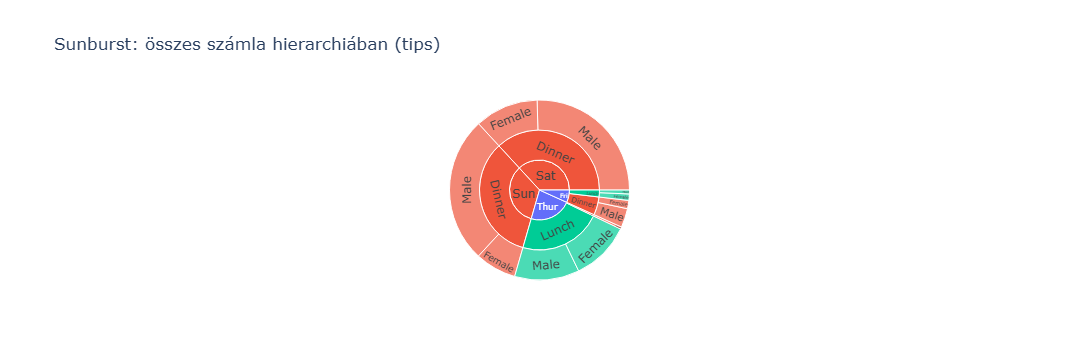

In [90]:
# 3) Sunburst: tippek – nap -> étkezés -> nem hierarchia
tips2 = tips.dropna(subset=['day', 'time', 'sex']).copy()

# konvertáljuk a kategorikus oszlopokat stringgé
for col in ['day', 'time', 'sex']:
    tips2[col] = tips2[col].astype(str)

import plotly.express as px

fig = px.sunburst(
    tips2,
    path=['day', 'time', 'sex'],
    values='total_bill',
    color='time',
    title='Sunburst: összes számla hierarchiában (tips)'
)
fig.show()



Következtetés: A teljes forgalom nagyobb része Dinnerhez köthető, és napok szerint is különbségek látszanak.


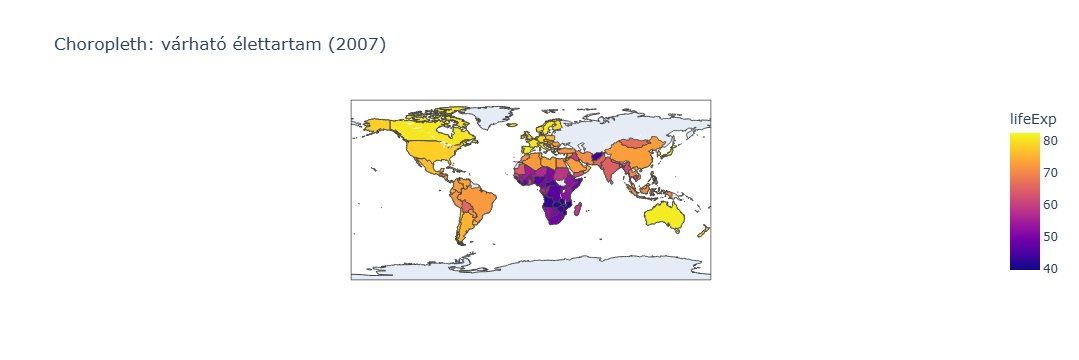

In [91]:
# 4) Choropleth: életkor várható hossza országonként (2007)
gap2007 = gap[gap['year'] == 2007]

fig = px.choropleth(
    gap2007,
    locations='iso_alpha',       # <<< ISO-3 country codes (recommended)
    color='lifeExp',
    hover_name='country',
    color_continuous_scale='Plasma',
    title='Choropleth: várható élettartam (2007)'
)

fig.show()


Következtetés: A fejlett országokban magasabb, míg a fejletlenebb régiókban alacsonyabb a várható élettartam.
